In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Dataset/Training.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/output/r034s007_60.png  
  inflating: Training/output/r034s007_9.png  
  inflating: Training/output/r034s008_0.png  
  inflating: Training/output/r034s008_12.png  
  inflating: Training/output/r034s008_15.png  
  inflating: Training/output/r034s008_18.png  
  inflating: Training/output/r034s008_21.png  
  inflating: Training/output/r034s008_24.png  
  inflating: Training/output/r034s008_27.png  
  inflating: Training/output/r034s008_3.png  
  inflating: Training/output/r034s008_30.png  
  inflating: Training/output/r034s008_33.png  
  inflating: Training/output/r034s008_36.png  
  inflating: Training/output/r034s008_39.png  
  inflating: Training/output/r034s008_42.png  
  inflating: Training/output/r034s008_45.png  
  inflating: Training/output/r034s008_48.png  
  inflating: Training/output/r034s008_51.png  
  inflating: Training/output/r034s008_54.png  
  inflating: Training/output/r034s008_57.png  
  inflating:

In [2]:
import cv2
import numpy as np
import os
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization,SpatialDropout2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, IoU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
import albumentations as A

class CustomDataGenerator(Sequence):
    def __init__(
        self,
        input_lst,
        output_lst,
        batch_size=32,
        shuffle=True,
        augmentation=True,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.input_lst = input_lst
        self.mask_lst = output_lst
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.n = len(input_lst)

        # Define augmentation pipeline (mask-safe)
        if self.augmentation:
            self.transform = A.Compose([
                # Spatial transforms (applied to BOTH image and mask)
                A.Rotate(limit=30, p=0.5),  # Rotate up to 30 degrees
                A.HorizontalFlip(p=0.5),    # Horizontal flip
                A.VerticalFlip(p=0.5),     # Vertical flip
                A.ShiftScaleRotate(
                    shift_limit=0.1,        # Shift by up to 10% of image size
                    scale_limit=0.2,        # Zoom in/out by up to 20%
                    rotate_limit=0,         # No additional rotation
                    p=0.5
                ),
                A.ElasticTransform(
                    alpha=1,               # Intensity of deformation
                    sigma=50,              # Smoothness of deformation
                    alpha_affine=50,       # Smoothness of affine transformation
                    p=0.5
                ),

                # Pixel-level transforms (applied ONLY to the image)
                A.RandomBrightnessContrast(
                    brightness_limit=0.2,
                    contrast_limit=0.2,
                    p=0.5
                ),
                A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Blur the image
                A.GaussNoise(var_limit=(10, 50), p=0.5),   # Add Gaussian noise
                A.RGBShift(
                    r_shift_limit=20,       # Shift red channel
                    g_shift_limit=20,       # Shift green channel
                    b_shift_limit=20,       # Shift blue channel
                    p=0.5
                ),
                A.CoarseDropout(
                    max_holes=8,           # Maximum number of holes
                    max_height=32,         # Maximum height of a hole
                    max_width=32,          # Maximum width of a hole
                    p=0.5
                ),
            ])
        else:
            self.transform = None

        self.on_epoch_end()

    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __get_data(self, files, label='input'):
        imgs = []
        for img_path in files:
            try:
                if label == 'input':
                    # Load and normalize input image
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = img.astype(np.float32) / 255.0
                else:
                    # Load and binarize mask
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = (img > 0).astype(np.uint8)  # Ensure 0/1 integers

                if img is None:
                    raise ValueError(f"Failed to load {img_path}")
                imgs.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                dummy_shape = (128, 128, 3) if label == 'input' else (128, 128)
                imgs.append(np.zeros(dummy_shape, dtype=np.float32 if label == 'input' else np.uint8))
        return np.array(imgs)

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        input_files = [self.input_lst[i] for i in indices]
        mask_files = [self.mask_lst[i] for i in indices]

        X = self.__get_data(input_files, label='input')  # (batch, H, W, 3)
        y = self.__get_data(mask_files, label='mask')    # (batch, H, W)

        if self.transform is not None:
            augmented_X, augmented_y = [], []
            for img, mask in zip(X, y):
                # Apply augmentation (brightness ONLY affects image)
                transformed = self.transform(image=img, mask=mask)
                augmented_X.append(transformed['image'])
                augmented_y.append(transformed['mask'])
            X = np.array(augmented_X)
            y = np.array(augmented_y)

        # Add channel dimension to masks
        y = np.expand_dims(y, axis=-1)
        return X, y

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

In [6]:
def unet_model(nfilters = 32, nclassess = 1, final_class_activation = 'sigmoid',activation = 'relu', kernel_initializer = 'he_normal' , input_size = (128, 128, 3)):
    inputs = Input(input_size)

    # Encoder (Downsampling)
    conv1 = Conv2D(nfilters*1, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer=kernel_initializer)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(nfilters*1, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer=kernel_initializer)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(nfilters*2, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer=kernel_initializer)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(nfilters*2, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-5), kernel_initializer=kernel_initializer)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = SpatialDropout2D(0.3)(pool2)

    conv3 = Conv2D(nfilters*4, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(drop2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(nfilters*4, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(nfilters*8, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(nfilters*8, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = SpatialDropout2D(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(nfilters*16, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(nfilters*16, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv5)
    conv5 = BatchNormalization()(conv5)

    # Decoder (Upsampling)
    up6 = Conv2DTranspose(nfilters*8, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(nfilters*8, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(nfilters*8, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2DTranspose(nfilters*4, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(nfilters*4, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(nfilters*4, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv7)
    conv7 = BatchNormalization()(conv7)
    drop7 = SpatialDropout2D(0.3)(conv7)

    up8 = Conv2DTranspose(nfilters*2, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(drop7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(nfilters*2, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(nfilters*2, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2DTranspose(nfilters*1, 2, strides=(2, 2), padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(nfilters*1, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(nfilters*1, 3, activation=activation, padding='same', kernel_regularizer=l2(1e-4), kernel_initializer=kernel_initializer)(conv9)
    conv9 = BatchNormalization()(conv9)
    drop9 = SpatialDropout2D(0.5)(conv9) 

    # Output layer
    outputs = Conv2D(nclassess, 1, activation=final_class_activation)(drop9)  

    model = Model(inputs, outputs)
    return model

In [7]:
from lesionSeg.models.loss import focal_tversky_loss
from lesionSeg.models.metrices import dice_coff

In [8]:
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
batch_size = 32

In [9]:
input_dir = "/content/Training/input"
output_dir = "/content/Training/output"

lst_input = sorted([os.path.join(input_dir, file) for file in os.listdir(input_dir)])
lst_output = sorted([os.path.join(output_dir, file) for file in os.listdir(output_dir)])

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/Training/input'

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(lst_input, lst_output, test_size=0.1, random_state=42)

In [11]:
len(X_train), len(y_train), len(X_valid), len(y_valid)

(12379, 12379, 1376, 1376)

In [12]:
train_loader = CustomDataGenerator(input_lst=X_train,
                                    output_lst=y_train,
                                    batch_size=batch_size,
                                   augmentation=True)
valid_loader = CustomDataGenerator(input_lst=X_valid,
                                    output_lst=y_valid,
                                    batch_size=batch_size,
                                   shuffle=False,
                                   augmentation=False)

In [13]:
X, y= train_loader[0]
X.shape, y.shape

((32, 128, 128, 3), (32, 128, 128, 1))

In [11]:
input_shape = (128, 128, 3)

model = unet_model()
# model.load_weights("/content/drive/MyDrive/Dataset/best_model.h5")
model.compile(
    optimizer=optimizer,
    loss=focal_tversky_loss,
    metrics=[
        dice_coff,
        IoU(num_classes=2, target_class_ids=[1], name='iou'),  # For class 1 (foreground)
        Precision(name='precision'),
        Recall(name='recall')
    ]
)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ spatial_dropout2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

None


In [15]:
# Save the best model based on validation IoU
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_iou",  # Use your IoU metric name
    mode="max",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

# Stop training if no improvement
early_stopping = EarlyStopping(
    monitor="val_iou",
    patience=15,
    mode="max",
    restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# TensorBoard for visualization
tensorboard = TensorBoard(log_dir="./logs")

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [17]:
history = model.fit(
    train_loader,
    epochs=100,
    validation_data=valid_loader,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - dice_coff: 0.2125 - iou: 0.1542 - loss: 0.8472 - precision: 0.3420 - recall: 0.2111
Epoch 1: val_iou improved from -inf to 0.36275, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 96s 248ms/step - dice_coff: 0.2126 - iou: 0.1542 - loss: 0.8471 - precision: 0.3420 - recall: 0.2112 - val_dice_coff: 0.4275 - val_iou: 0.3627 - val_loss: 0.6642 - val_precision: 0.6588 - val_recall: 0.4487 - learning_rate: 1.0000e-04
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.2167 - iou: 0.1615 - loss: 0.8408 - precision: 0.3365 - recall: 0.2370
Epoch 2: val_iou improved from 0.36275 to 0.36845, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 110s 166ms/step - dice_coff: 0.2168 - iou: 0.1616 - loss: 0.8407 - precision: 0.3366 - recall: 0.2370 - val_dice_coff: 0.4372 - val_iou: 0.3684 - val_loss: 0.6797 - val_precision: 0.5506 - val_recall: 0.5240 - learning_rate: 1.0000e-04
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.2960 - iou: 0.2184 - loss: 0.7706 - precision: 0.4365 - recall: 0.3068
Epoch 3: val_iou did not improve from 0.36845
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.2960 - iou: 0.2184 - loss: 0.7706 - precision: 0.4364 - recall: 0.3068 - val_dice_coff: 0.4151 - val_iou: 0.3490 - val_loss: 0.7076 - val_precision: 0.4962 - val_recall: 0.5341 - learning_rate: 1.0000e-04
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.3073 - iou: 0.2284 - loss: 0.7553 - precision: 0.5036 - recall: 0.2985
Epoch 4: val_iou did not improve from 0.36845
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.3073 - iou: 0.2284 - loss: 0.7553 - pr

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - dice_coff: 0.3575 - iou: 0.2724 - loss: 0.7164 - precision: 0.5143 - recall: 0.3696 - val_dice_coff: 0.4488 - val_iou: 0.3808 - val_loss: 0.6711 - val_precision: 0.5648 - val_recall: 0.5336 - learning_rate: 2.0000e-05
Epoch 10/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3977 - iou: 0.2907 - loss: 0.6780 - precision: 0.5859 - recall: 0.3701
Epoch 10: val_iou improved from 0.38075 to 0.40247, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - dice_coff: 0.3977 - iou: 0.2907 - loss: 0.6780 - precision: 0.5859 - recall: 0.3701 - val_dice_coff: 0.4747 - val_iou: 0.4025 - val_loss: 0.6411 - val_precision: 0.6099 - val_recall: 0.5374 - learning_rate: 2.0000e-05
Epoch 11/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.3725 - iou: 0.2794 - loss: 0.7031 - precision: 0.5437 - recall: 0.3675
Epoch 11: val_iou did not improve from 0.40247
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3725 - iou: 0.2794 - loss: 0.7031 - precision: 0.5437 - recall: 0.3675 - val_dice_coff: 0.4376 - val_iou: 0.3683 - val_loss: 0.6882 - val_precision: 0.5230 - val_recall: 0.5457 - learning_rate: 2.0000e-05
Epoch 12/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3933 - iou: 0.2970 - loss: 0.6862 - precision: 0.5339 - recall: 0.4000
Epoch 12: val_iou did not improve from 0.40247
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3933 - iou: 0.2970 - loss: 0.6862 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 65s 167ms/step - dice_coff: 0.3930 - iou: 0.3167 - loss: 0.6855 - precision: 0.5764 - recall: 0.4149 - val_dice_coff: 0.4848 - val_iou: 0.4026 - val_loss: 0.6307 - val_precision: 0.6046 - val_recall: 0.5436 - learning_rate: 2.0000e-05
Epoch 18/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3756 - iou: 0.3034 - loss: 0.7007 - precision: 0.5622 - recall: 0.3987
Epoch 18: val_iou did not improve from 0.40264
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - dice_coff: 0.3757 - iou: 0.3034 - loss: 0.7007 - precision: 0.5622 - recall: 0.3987 - val_dice_coff: 0.4837 - val_iou: 0.3988 - val_loss: 0.6368 - val_precision: 0.5704 - val_recall: 0.5608 - learning_rate: 2.0000e-05
Epoch 19/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.4042 - iou: 0.3171 - loss: 0.6783 - precision: 0.5561 - recall: 0.4276
Epoch 19: val_iou improved from 0.40264 to 0.40984, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - dice_coff: 0.4042 - iou: 0.3170 - loss: 0.6783 - precision: 0.5561 - recall: 0.4276 - val_dice_coff: 0.4837 - val_iou: 0.4098 - val_loss: 0.6238 - val_precision: 0.6475 - val_recall: 0.5256 - learning_rate: 2.0000e-05
Epoch 20/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3967 - iou: 0.3101 - loss: 0.6787 - precision: 0.5945 - recall: 0.3972
Epoch 20: val_iou did not improve from 0.40984
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3967 - iou: 0.3101 - loss: 0.6787 - precision: 0.5945 - recall: 0.3972 - val_dice_coff: 0.4768 - val_iou: 0.4060 - val_loss: 0.6416 - val_precision: 0.5919 - val_recall: 0.5569 - learning_rate: 2.0000e-05
Epoch 21/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3946 - iou: 0.3015 - loss: 0.6774 - precision: 0.6064 - recall: 0.3768
Epoch 21: val_iou did not improve from 0.40984
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3946 - iou: 0.3015 - loss: 0.6774 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - dice_coff: 0.4053 - iou: 0.3239 - loss: 0.6668 - precision: 0.6492 - recall: 0.3974 - val_dice_coff: 0.4858 - val_iou: 0.4114 - val_loss: 0.6243 - val_precision: 0.6349 - val_recall: 0.5365 - learning_rate: 4.0000e-06
Epoch 26/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.3782 - iou: 0.3152 - loss: 0.6943 - precision: 0.6257 - recall: 0.3911
Epoch 26: val_iou improved from 0.41137 to 0.41499, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 65s 167ms/step - dice_coff: 0.3783 - iou: 0.3152 - loss: 0.6943 - precision: 0.6257 - recall: 0.3911 - val_dice_coff: 0.4947 - val_iou: 0.4150 - val_loss: 0.6195 - val_precision: 0.6156 - val_recall: 0.5557 - learning_rate: 4.0000e-06
Epoch 27/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.4393 - iou: 0.3518 - loss: 0.6404 - precision: 0.6627 - recall: 0.4334
Epoch 27: val_iou improved from 0.41499 to 0.41789, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - dice_coff: 0.4393 - iou: 0.3518 - loss: 0.6404 - precision: 0.6627 - recall: 0.4334 - val_dice_coff: 0.4921 - val_iou: 0.4179 - val_loss: 0.6192 - val_precision: 0.6328 - val_recall: 0.5492 - learning_rate: 4.0000e-06
Epoch 28/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.3976 - iou: 0.3414 - loss: 0.6732 - precision: 0.6577 - recall: 0.4189
Epoch 28: val_iou did not improve from 0.41789
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3977 - iou: 0.3414 - loss: 0.6732 - precision: 0.6577 - recall: 0.4189 - val_dice_coff: 0.4915 - val_iou: 0.4166 - val_loss: 0.6199 - val_precision: 0.6297 - val_recall: 0.5474 - learning_rate: 4.0000e-06
Epoch 29/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.4401 - iou: 0.3507 - loss: 0.6420 - precision: 0.6643 - recall: 0.4305
Epoch 29: val_iou improved from 0.41789 to 0.42136, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - dice_coff: 0.4401 - iou: 0.3507 - loss: 0.6421 - precision: 0.6644 - recall: 0.4305 - val_dice_coff: 0.4983 - val_iou: 0.4214 - val_loss: 0.6110 - val_precision: 0.6452 - val_recall: 0.5463 - learning_rate: 4.0000e-06
Epoch 30/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - dice_coff: 0.4089 - iou: 0.3367 - loss: 0.6628 - precision: 0.6718 - recall: 0.4082
Epoch 30: val_iou did not improve from 0.42136
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4089 - iou: 0.3367 - loss: 0.6628 - precision: 0.6717 - recall: 0.4082 - val_dice_coff: 0.4949 - val_iou: 0.4193 - val_loss: 0.6191 - val_precision: 0.6232 - val_recall: 0.5569 - learning_rate: 4.0000e-06
Epoch 31/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - dice_coff: 0.4008 - iou: 0.3316 - loss: 0.6742 - precision: 0.6283 - recall: 0.4169
Epoch 31: val_iou did not improve from 0.42136
387/387 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - dice_coff: 0.4008 - iou: 0.3315 - loss: 0.6742 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.3866 - iou: 0.3159 - loss: 0.6894 - precision: 0.6043 - recall: 0.4012 - val_dice_coff: 0.4950 - val_iou: 0.4215 - val_loss: 0.6105 - val_precision: 0.6617 - val_recall: 0.5366 - learning_rate: 1.0000e-06
Epoch 38/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4469 - iou: 0.3552 - loss: 0.6280 - precision: 0.6824 - recall: 0.4299
Epoch 38: val_iou improved from 0.42154 to 0.42260, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4469 - iou: 0.3551 - loss: 0.6280 - precision: 0.6823 - recall: 0.4299 - val_dice_coff: 0.4959 - val_iou: 0.4226 - val_loss: 0.6075 - val_precision: 0.6713 - val_recall: 0.5321 - learning_rate: 1.0000e-06
Epoch 39/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4417 - iou: 0.3451 - loss: 0.6366 - precision: 0.6663 - recall: 0.4235
Epoch 39: val_iou did not improve from 0.42260
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4417 - iou: 0.3450 - loss: 0.6366 - precision: 0.6663 - recall: 0.4235 - val_dice_coff: 0.4944 - val_iou: 0.4196 - val_loss: 0.6166 - val_precision: 0.6351 - val_recall: 0.5504 - learning_rate: 1.0000e-06
Epoch 40/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4077 - iou: 0.3331 - loss: 0.6638 - precision: 0.6537 - recall: 0.4098
Epoch 40: val_iou did not improve from 0.42260
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4077 - iou: 0.3331 - loss: 0.6638 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4393 - iou: 0.3567 - loss: 0.6413 - precision: 0.6579 - recall: 0.4423 - val_dice_coff: 0.4952 - val_iou: 0.4228 - val_loss: 0.6115 - val_precision: 0.6569 - val_recall: 0.5400 - learning_rate: 1.0000e-06
Epoch 42/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4421 - iou: 0.3589 - loss: 0.6345 - precision: 0.6872 - recall: 0.4332
Epoch 42: val_iou did not improve from 0.42282
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - dice_coff: 0.4420 - iou: 0.3588 - loss: 0.6345 - precision: 0.6872 - recall: 0.4332 - val_dice_coff: 0.4922 - val_iou: 0.4188 - val_loss: 0.6188 - val_precision: 0.6349 - val_recall: 0.5498 - learning_rate: 1.0000e-06
Epoch 43/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4380 - iou: 0.3616 - loss: 0.6361 - precision: 0.6903 - recall: 0.4362
Epoch 43: val_iou did not improve from 0.42282
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - dice_coff: 0.4380 - iou: 0.3615 - loss: 0.6362 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4515 - iou: 0.3740 - loss: 0.6281 - precision: 0.6934 - recall: 0.4521 - val_dice_coff: 0.4976 - val_iou: 0.4233 - val_loss: 0.6097 - val_precision: 0.6555 - val_recall: 0.5434 - learning_rate: 1.0000e-06
Epoch 52/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.3945 - iou: 0.3347 - loss: 0.6796 - precision: 0.6371 - recall: 0.4173
Epoch 52: val_iou did not improve from 0.42327
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.3946 - iou: 0.3347 - loss: 0.6796 - precision: 0.6372 - recall: 0.4174 - val_dice_coff: 0.4961 - val_iou: 0.4220 - val_loss: 0.6138 - val_precision: 0.6424 - val_recall: 0.5498 - learning_rate: 1.0000e-06
Epoch 53/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4349 - iou: 0.3642 - loss: 0.6415 - precision: 0.6753 - recall: 0.4456
Epoch 53: val_iou improved from 0.42327 to 0.42349, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4349 - iou: 0.3642 - loss: 0.6415 - precision: 0.6753 - recall: 0.4456 - val_dice_coff: 0.4982 - val_iou: 0.4235 - val_loss: 0.6116 - val_precision: 0.6438 - val_recall: 0.5508 - learning_rate: 1.0000e-06
Epoch 54/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4366 - iou: 0.3642 - loss: 0.6407 - precision: 0.6793 - recall: 0.4433
Epoch 54: val_iou did not improve from 0.42349
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4366 - iou: 0.3642 - loss: 0.6407 - precision: 0.6793 - recall: 0.4433 - val_dice_coff: 0.4979 - val_iou: 0.4211 - val_loss: 0.6163 - val_precision: 0.6239 - val_recall: 0.5616 - learning_rate: 1.0000e-06
Epoch 55/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4536 - iou: 0.3544 - loss: 0.6266 - precision: 0.6527 - recall: 0.4408
Epoch 55: val_iou improved from 0.42349 to 0.42527, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4535 - iou: 0.3544 - loss: 0.6266 - precision: 0.6527 - recall: 0.4408 - val_dice_coff: 0.4997 - val_iou: 0.4253 - val_loss: 0.6077 - val_precision: 0.6572 - val_recall: 0.5454 - learning_rate: 1.0000e-06
Epoch 56/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4194 - iou: 0.3444 - loss: 0.6543 - precision: 0.6688 - recall: 0.4198
Epoch 56: val_iou did not improve from 0.42527
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4195 - iou: 0.3444 - loss: 0.6543 - precision: 0.6687 - recall: 0.4198 - val_dice_coff: 0.4992 - val_iou: 0.4222 - val_loss: 0.6140 - val_precision: 0.6289 - val_recall: 0.5599 - learning_rate: 1.0000e-06
Epoch 57/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4208 - iou: 0.3444 - loss: 0.6522 - precision: 0.6762 - recall: 0.4178
Epoch 57: val_iou did not improve from 0.42527
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4208 - iou: 0.3444 - loss: 0.6522 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - dice_coff: 0.4363 - iou: 0.3614 - loss: 0.6400 - precision: 0.6698 - recall: 0.4457 - val_dice_coff: 0.5016 - val_iou: 0.4264 - val_loss: 0.6050 - val_precision: 0.6616 - val_recall: 0.5442 - learning_rate: 1.0000e-06
Epoch 59/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4399 - iou: 0.3581 - loss: 0.6407 - precision: 0.6524 - recall: 0.4472
Epoch 59: val_iou did not improve from 0.42639
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - dice_coff: 0.4399 - iou: 0.3581 - loss: 0.6407 - precision: 0.6525 - recall: 0.4472 - val_dice_coff: 0.5002 - val_iou: 0.4256 - val_loss: 0.6060 - val_precision: 0.6631 - val_recall: 0.5424 - learning_rate: 1.0000e-06
Epoch 60/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4574 - iou: 0.3703 - loss: 0.6207 - precision: 0.6978 - recall: 0.4457
Epoch 60: val_iou did not improve from 0.42639
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4574 - iou: 0.3703 - loss: 0.6208 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - dice_coff: 0.4493 - iou: 0.3525 - loss: 0.6271 - precision: 0.6832 - recall: 0.4261 - val_dice_coff: 0.5022 - val_iou: 0.4277 - val_loss: 0.6036 - val_precision: 0.6667 - val_recall: 0.5428 - learning_rate: 1.0000e-06
Epoch 62/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4359 - iou: 0.3616 - loss: 0.6410 - precision: 0.6815 - recall: 0.4389
Epoch 62: val_iou improved from 0.42773 to 0.42793, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4360 - iou: 0.3616 - loss: 0.6410 - precision: 0.6815 - recall: 0.4389 - val_dice_coff: 0.5026 - val_iou: 0.4279 - val_loss: 0.6011 - val_precision: 0.6767 - val_recall: 0.5380 - learning_rate: 1.0000e-06
Epoch 63/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4077 - iou: 0.3464 - loss: 0.6657 - precision: 0.6507 - recall: 0.4306
Epoch 63: val_iou did not improve from 0.42793
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 164ms/step - dice_coff: 0.4077 - iou: 0.3465 - loss: 0.6657 - precision: 0.6508 - recall: 0.4306 - val_dice_coff: 0.4987 - val_iou: 0.4239 - val_loss: 0.6134 - val_precision: 0.6347 - val_recall: 0.5574 - learning_rate: 1.0000e-06
Epoch 64/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - dice_coff: 0.4191 - iou: 0.3424 - loss: 0.6598 - precision: 0.6492 - recall: 0.4241
Epoch 64: val_iou improved from 0.42793 to 0.42837, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - dice_coff: 0.4192 - iou: 0.3424 - loss: 0.6597 - precision: 0.6493 - recall: 0.4241 - val_dice_coff: 0.5027 - val_iou: 0.4284 - val_loss: 0.6016 - val_precision: 0.6734 - val_recall: 0.5401 - learning_rate: 1.0000e-06
Epoch 65/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4599 - iou: 0.3680 - loss: 0.6178 - precision: 0.6869 - recall: 0.4481
Epoch 65: val_iou did not improve from 0.42837
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4598 - iou: 0.3679 - loss: 0.6179 - precision: 0.6868 - recall: 0.4481 - val_dice_coff: 0.5011 - val_iou: 0.4265 - val_loss: 0.6065 - val_precision: 0.6573 - val_recall: 0.5468 - learning_rate: 1.0000e-06
Epoch 66/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4158 - iou: 0.3503 - loss: 0.6605 - precision: 0.6653 - recall: 0.4311
Epoch 66: val_iou did not improve from 0.42837
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4158 - iou: 0.3503 - loss: 0.6604 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4215 - iou: 0.3512 - loss: 0.6550 - precision: 0.6490 - recall: 0.4365 - val_dice_coff: 0.5039 - val_iou: 0.4294 - val_loss: 0.6018 - val_precision: 0.6671 - val_recall: 0.5442 - learning_rate: 1.0000e-06
Epoch 76/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4319 - iou: 0.3563 - loss: 0.6456 - precision: 0.6734 - recall: 0.4347
Epoch 76: val_iou did not improve from 0.42936
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - dice_coff: 0.4319 - iou: 0.3563 - loss: 0.6456 - precision: 0.6734 - recall: 0.4347 - val_dice_coff: 0.5014 - val_iou: 0.4260 - val_loss: 0.6103 - val_precision: 0.6397 - val_recall: 0.5579 - learning_rate: 1.0000e-06
Epoch 77/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4156 - iou: 0.3462 - loss: 0.6636 - precision: 0.6509 - recall: 0.4286
Epoch 77: val_iou improved from 0.42936 to 0.43094, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4156 - iou: 0.3462 - loss: 0.6636 - precision: 0.6509 - recall: 0.4286 - val_dice_coff: 0.5050 - val_iou: 0.4309 - val_loss: 0.5981 - val_precision: 0.6814 - val_recall: 0.5382 - learning_rate: 1.0000e-06
Epoch 78/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4043 - iou: 0.3319 - loss: 0.6705 - precision: 0.6387 - recall: 0.4115
Epoch 78: val_iou improved from 0.43094 to 0.43098, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4043 - iou: 0.3320 - loss: 0.6704 - precision: 0.6388 - recall: 0.4116 - val_dice_coff: 0.5062 - val_iou: 0.4310 - val_loss: 0.6010 - val_precision: 0.6628 - val_recall: 0.5499 - learning_rate: 1.0000e-06
Epoch 79/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4298 - iou: 0.3501 - loss: 0.6440 - precision: 0.6756 - recall: 0.4261
Epoch 79: val_iou did not improve from 0.43098
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4297 - iou: 0.3501 - loss: 0.6441 - precision: 0.6756 - recall: 0.4261 - val_dice_coff: 0.5023 - val_iou: 0.4257 - val_loss: 0.6128 - val_precision: 0.6253 - val_recall: 0.5674 - learning_rate: 1.0000e-06
Epoch 80/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4454 - iou: 0.3600 - loss: 0.6350 - precision: 0.6651 - recall: 0.4447
Epoch 80: val_iou improved from 0.43098 to 0.43206, saving model to best_model.h5


387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4454 - iou: 0.3600 - loss: 0.6350 - precision: 0.6651 - recall: 0.4447 - val_dice_coff: 0.5070 - val_iou: 0.4321 - val_loss: 0.6009 - val_precision: 0.6605 - val_recall: 0.5533 - learning_rate: 1.0000e-06
Epoch 81/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4234 - iou: 0.3495 - loss: 0.6531 - precision: 0.6723 - recall: 0.4251
Epoch 81: val_iou did not improve from 0.43206
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4234 - iou: 0.3495 - loss: 0.6531 - precision: 0.6722 - recall: 0.4251 - val_dice_coff: 0.5043 - val_iou: 0.4298 - val_loss: 0.6026 - val_precision: 0.6635 - val_recall: 0.5477 - learning_rate: 1.0000e-06
Epoch 82/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4422 - iou: 0.3703 - loss: 0.6331 - precision: 0.6908 - recall: 0.4487
Epoch 82: val_iou did not improve from 0.43206
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4422 - iou: 0.3703 - loss: 0.6331 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 166ms/step - dice_coff: 0.4339 - iou: 0.3444 - loss: 0.6449 - precision: 0.6414 - recall: 0.4311 - val_dice_coff: 0.5104 - val_iou: 0.4332 - val_loss: 0.5951 - val_precision: 0.6731 - val_recall: 0.5468 - learning_rate: 1.0000e-06
Epoch 91/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4094 - iou: 0.3344 - loss: 0.6673 - precision: 0.6260 - recall: 0.4217
Epoch 91: val_iou did not improve from 0.43322
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4094 - iou: 0.3345 - loss: 0.6673 - precision: 0.6260 - recall: 0.4217 - val_dice_coff: 0.5092 - val_iou: 0.4312 - val_loss: 0.5997 - val_precision: 0.6574 - val_recall: 0.5539 - learning_rate: 1.0000e-06
Epoch 92/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - dice_coff: 0.4166 - iou: 0.3441 - loss: 0.6593 - precision: 0.6507 - recall: 0.4272
Epoch 92: val_iou did not improve from 0.43322
387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - dice_coff: 0.4166 - iou: 0.3441 - loss: 0.6593 -

387/387 ━━━━━━━━━━━━━━━━━━━━ 64s 165ms/step - dice_coff: 0.4442 - iou: 0.3621 - loss: 0.6313 - precision: 0.6934 - recall: 0.4358 - val_dice_coff: 0.5114 - val_iou: 0.4336 - val_loss: 0.5939 - val_precision: 0.6771 - val_recall: 0.5455 - learning_rate: 1.0000e-06
Epoch 97/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4565 - iou: 0.3687 - loss: 0.6238 - precision: 0.6921 - recall: 0.4461
Epoch 97: val_iou did not improve from 0.43358
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4565 - iou: 0.3687 - loss: 0.6238 - precision: 0.6921 - recall: 0.4461 - val_dice_coff: 0.5108 - val_iou: 0.4332 - val_loss: 0.5944 - val_precision: 0.6774 - val_recall: 0.5447 - learning_rate: 1.0000e-06
Epoch 98/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - dice_coff: 0.4378 - iou: 0.3497 - loss: 0.6356 - precision: 0.6983 - recall: 0.4180
Epoch 98: val_iou did not improve from 0.43358
387/387 ━━━━━━━━━━━━━━━━━━━━ 63s 163ms/step - dice_coff: 0.4378 - iou: 0.3497 - loss: 0.6356 -

In [18]:
!zip -r /content/logs.zip /content/logs

  adding: content/logs/ (stored 0%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1739831264.91f92341f389.1037.1.v2 (deflated 87%)
  adding: content/logs/train/events.out.tfevents.1739831199.91f92341f389.1037.0.v2 (deflated 95%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1739831351.91f92341f389.1037.2.v2 (deflated 79%)


load the model

In [34]:
X, y = train_loader[0]

In [35]:
X.shape, y.shape

((32, 128, 128, 3), (32, 128, 128, 1))

In [59]:
import matplotlib.pyplot as plt

X_img = X[1]
y_img = y[22]

X.shape

(32, 128, 128, 3)

In [60]:
y.min(), y.max()

(0, 1)

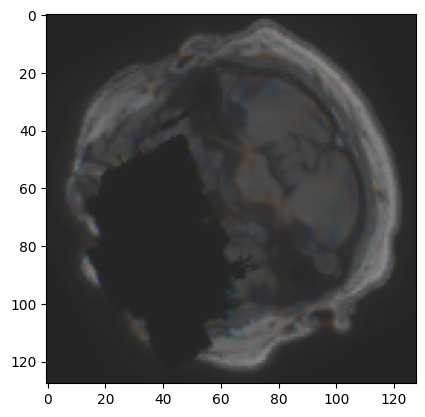

In [61]:
plt.imshow(X_img)

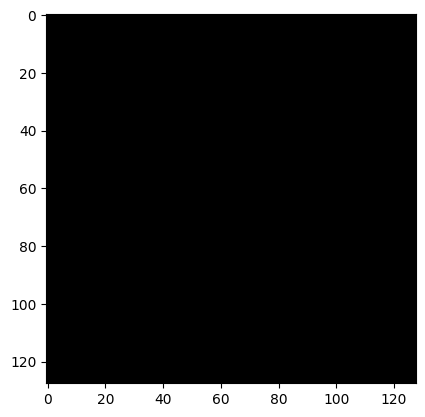

In [62]:
plt.imshow(y_img, cmap='grey')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


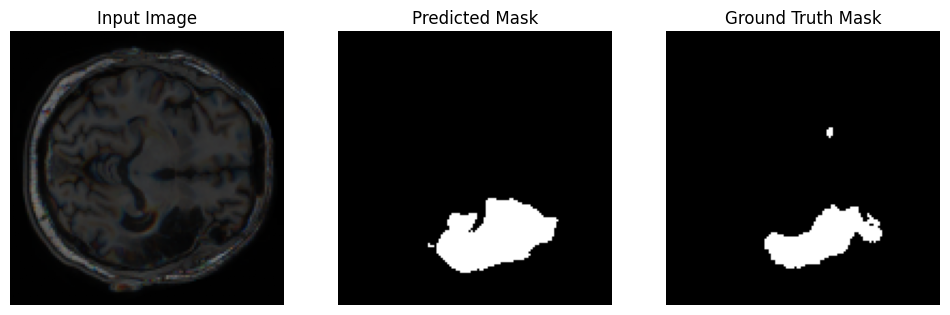

In [65]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Load the Trained Model
model = load_model('/content/best_model.h5', custom_objects={
    'focal_tversky_loss': focal_tversky_loss,
        'dice_coff': dice_coff,
        'IoU': IoU,
        'Precision': Precision,
        'Recall': Recall
})

# Step 2: Preprocess the Input Data
def preprocess_image(image_path, target_size=(128, 128)):
    # Load and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to match model input size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Step 3: Run Inference
def predict_mask(model, image):
    pred_mask = model.predict(image)  # Predict mask
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold (0.5)
    return pred_mask[0]  # Remove batch dimension

# Step 4: Visualize the Results
def visualize_prediction(image, pred_mask, ground_truth_mask=None):
    plt.figure(figsize=(12, 6))

    # Plot Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Plot Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    # Plot Ground Truth Mask (if available)
    if ground_truth_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

    plt.show()

# Step 5: Predict and Visualize for a Single Image
image_path = '/content/Training/input/r001s002_60.png'  # Replace with your image path
image = preprocess_image(image_path)
pred_mask = predict_mask(model, image)

# If you have the ground truth mask, load and preprocess it
ground_truth_mask_path = '/content/Training/output/r001s002_60.png'  # Replace with your mask path (if available)
ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
ground_truth_mask = cv2.resize(ground_truth_mask, (128, 128))  # Resize to match prediction
ground_truth_mask = (ground_truth_mask > 0).astype(np.uint8)  # Binarize

# Visualize the results
visualize_prediction(image[0], pred_mask, ground_truth_mask)

In [67]:
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# --- Helper Functions for Preprocessing ---
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess input image."""
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Unable to load image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, target_size)          # Resize to model input size
    image = image / 255.0                             # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)             # Add batch dimension
    return image

def preprocess_mask(mask_path, target_size=(128, 128)):
    """Load and preprocess ground truth mask."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Unable to load mask at {mask_path}")
    mask = cv2.resize(mask, target_size)              # Resize mask to target size
    # Binarize mask: set all positive values to 1.
    mask = (mask > 0).astype(np.uint8)
    return mask

def predict_mask(model, image):
    """Predict mask for a given preprocessed image."""
    pred_mask = model.predict(image)                # Predict mask from model
    pred_mask = (pred_mask > 0.5).astype(np.uint8)    # Threshold prediction
    return pred_mask[0]  # Remove batch dimension

# --- Visualization Function ---
def visualize_and_save(image, pred_mask, ground_truth_mask, save_path):
    """
    Visualizes and saves a figure with:
      1. The input image.
      2. The predicted mask.
      3. The ground truth mask.
    Axes, labels, and titles are kept in the saved figure.
    """
    plt.figure(figsize=(15, 5))

    # Plot Input Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Plot Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # Plot Ground Truth Mask
    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

# --- Load the Trained Model with Custom Objects ---
model = load_model('/content/best_model.h5', custom_objects={
    'focal_tversky_loss': focal_tversky_loss,
    'dice_coff': dice_coff,
    'IoU': IoU,
    'Precision': Precision,
    'Recall': Recall
})

# --- Predict Multiple Images, Including Ground Truth Masks ---
def predict_multiple(model, input_paths, required_with=2, required_without=2, seg_threshold=10):
    """
    Loops over input image paths and predicts segmentation masks.
    For each input image, the function attempts to load the corresponding
    ground truth mask from a parallel folder structure.

    The input image path is expected to be in a folder named "input", and
    the corresponding ground truth mask should be in a folder named "output"
    with the same file name.
    """
    with_seg = []     # List of tuples: (img_path, img, pred_mask, gt_mask)
    without_seg = []

    for path in input_paths:
        try:
            # Preprocess input image.
            img = preprocess_image(path)
            pred_mask = predict_mask(model, img)

            # Construct corresponding ground truth mask path.
            gt_path = path.replace('/input/', '/output/')
            gt_mask = preprocess_mask(gt_path)

            # Define "segmentation" if sum of mask pixels is above threshold.
            if np.sum(pred_mask) > seg_threshold:
                with_seg.append((path, img, pred_mask, gt_mask))
            else:
                without_seg.append((path, img, pred_mask, gt_mask))
        except Exception as e:
            print(f"Error processing {path}: {e}")

        # Break early if we've collected enough samples from both groups.
        if len(with_seg) >= required_with and len(without_seg) >= required_without:
            break

    selected = with_seg[:required_with] + without_seg[:required_without]
    return selected

# --- Get All Image Paths from the Input Folder ---
all_image_paths = glob.glob('/content/Training/input/*.png')

# --- Get Four Predictions: Two With Segmentation and Two Without ---
selected_predictions = predict_multiple(model, all_image_paths,
                                          required_with=2, required_without=2,
                                          seg_threshold=10)  # Adjust threshold if needed

# --- Visualize and Save the Selected Predictions ---
for path, img_batch, pred_mask, gt_mask in selected_predictions:
    print(f"Processing Image: {path}")
    # Remove batch dimension for visualization (img_batch shape: (1, H, W, 3))
    img = img_batch[0]
    # Define a save path (you can adjust the folder/filename as desired)
    save_path = path.split('/')[-1].replace('.png', '_prediction.png')
    visualize_and_save(img, pred_mask, gt_mask, save_path)
    print(f"Saved result to: {save_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

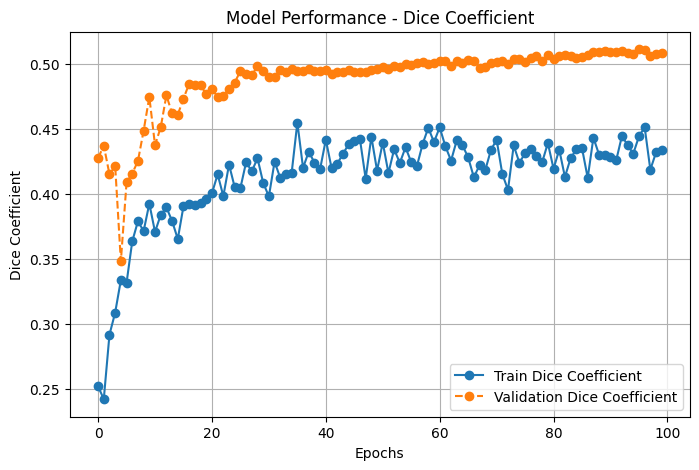

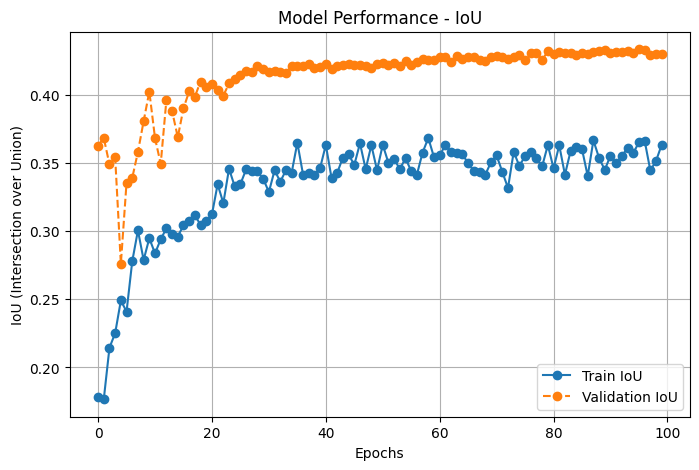

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load training and validation logs
train_log_path = "dic_train.csv"  # Replace with your actual file path
val_log_path = "dic_validation.csv"  # Replace with your actual file path
iou_train_log_path = "iou_train.csv"  # Replace with your actual file path
iou_val_log_path = "iou_validation.csv"  # Replace with your actual file path

dic_train_df = pd.read_csv(train_log_path)
dic_val_df = pd.read_csv(val_log_path)

iou_train_df = pd.read_csv(iou_train_log_path)
iou_val_df = pd.read_csv(iou_val_log_path)

# Extract the required metrics
epochs = dic_train_df["Step"]
train_dice = dic_train_df["Value"]
val_dice = dic_val_df["Value"]

train_iou = iou_train_df["Value"]
val_iou = iou_val_df["Value"]

# Create save directory
save_dir = "plots"
os.makedirs(save_dir, exist_ok=True)

# Plot Dice Coefficient
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_dice, label="Train Dice Coefficient", marker='o')
plt.plot(epochs, val_dice, label="Validation Dice Coefficient", marker='o', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.title("Model Performance - Dice Coefficient")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir, "dice_coefficient.png"))
plt.show()

# Plot IoU
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_iou, label="Train IoU", marker='o')
plt.plot(epochs, val_iou, label="Validation IoU", marker='o', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("IoU (Intersection over Union)")
plt.title("Model Performance - IoU")
plt.legend()
plt.grid()
plt.savefig(os.path.join(save_dir, "iou_plot.png"))
plt.show()
